# Bitcoin Price Prediction

**Problem Type** 
<br>
Supervised learning regression problem for time series forecasting

**Objective**  
Predict Bitcoin closing price (BTC Close) using:
- Historical Bitcoin data (Open, High, Low, Volume)
- NASDAQ market data (Open, High, Low, Close, Volume)
- Gold market data (Open, High, Low, Close, Volume)
- Technical indicator (Trend)

**Flow**
1) Data collection and EDA
2) Initial predictive model
3) Feature engineering and selection
4) Improved predictive model
5) Model evaluation and conclusion

# 1. Data Collection and EDA

## Setup function to fetch data

In [1]:
import yfinance as yf
import pandas as pd
from rich.console import Console
from rich.table import Table

console = Console()

def fetch_market_data(start_date='2014-09-17', end_date='2025-06-09', verbose=True):
    """
    Fetch and process market data for Bitcoin, NASDAQ, and Gold.
    
    Parameters:x
    -----------
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    verbose : bool
        Whether to print progress information
        
    Returns:
    --------
    pd.DataFrame
        Processed market data with all features
    """
    try:
        if verbose:
            console.print("[bold yellow]🔍 Fetching market data...[/bold yellow]")
            console.print(f"[bold]📅 Date range:[/bold] {start_date} to {end_date}")
        
        # Fetch Bitcoin data
        if verbose:
            console.print("\n[bold yellow]📊 Fetching Bitcoin data...[/bold yellow]")
        btc = yf.download('BTC-USD', start=start_date, end=end_date, progress=False)
        # The data comes with a MultiIndex structure like:
        # MultiIndex([('Open', 'BTC-USD'), ('High', 'BTC-USD'), ...])
        # We use xs to get the 'BTC-USD' level
        btc = btc.xs('BTC-USD', level='Ticker', axis=1)
        
        # Fetch NASDAQ data
        if verbose:
            console.print("[bold yellow]📈 Fetching NASDAQ data...[/bold yellow]")
        nasdaq = yf.download('^IXIC', start=start_date, end=end_date, progress=False)
        nasdaq = nasdaq.xs('^IXIC', level='Ticker', axis=1)
        
        # Fetch Gold data
        if verbose:
            console.print("[bold yellow]💰 Fetching Gold data...[/bold yellow]")
        gold = yf.download('GC=F', start=start_date, end=end_date, progress=False)
        gold = gold.xs('GC=F', level='Ticker', axis=1)
        
        # Data validation
        if btc.empty or nasdaq.empty or gold.empty:
            console.print("[bold red]⚠️ Warning: One or more dataframes are empty![/bold red]")
            return None
            
        # Create a new DataFrame with Bitcoin dates as the index
        data = pd.DataFrame(index=btc.index)
        data['Date'] = data.index
        
        # Process Bitcoin data
        if verbose:
            console.print("\n[bold green]🔄 Processing Bitcoin data...[/bold green]")
        data['BTC Open'] = btc['Open'].round(6)
        data['BTC High'] = btc['High'].round(6)
        data['BTC Low'] = btc['Low'].round(6)
        data['BTC Close'] = btc['Close'].round(6)
        data['BTC Volume'] = btc['Volume'].astype(int)
        
        # Process NASDAQ data
        if verbose:
            console.print("[bold green]🔄 Processing NASDAQ data...[/bold green]")
        nasdaq = nasdaq.reindex(btc.index, method='ffill')
        data['NASDAQ Open'] = nasdaq['Open'].round(6)
        data['NASDAQ High'] = nasdaq['High'].round(6)
        data['NASDAQ Low'] = nasdaq['Low'].round(6)
        data['NASDAQ Close'] = nasdaq['Close'].round(6)
        data['NASDAQ Volume'] = nasdaq['Volume'].astype(int)
        
        # Process Gold data
        if verbose:
            console.print("[bold green]🔄 Processing Gold data...[/bold green]")
        gold = gold.reindex(btc.index, method='ffill')
        data['Gold Open'] = gold['Open'].round(1)
        data['Gold High'] = gold['High'].round(1)
        data['Gold Low'] = gold['Low'].round(1)
        data['Gold Close'] = gold['Close'].round(1)
        data['Gold Volume'] = gold['Volume'].astype(int)
        
        # Calculate trend
        if verbose:
            console.print("[bold green]📈 Calculating trend...[/bold green]")
        data['Trend'] = (data['BTC Close'] > data['BTC Open']).astype(int) * 2 - 1
        
        if verbose:
            console.print("\n[bold green]✅ Data processing complete![/bold green]")
            
            # Create a summary table
            table = Table(title="Data Summary")
            table.add_column("Metric", style="cyan")
            table.add_column("Value", style="magenta")
            
            table.add_row("Total rows", str(len(data)))
            table.add_row("Date range", f"{data['Date'].min()} to {data['Date'].max()}")
            table.add_row("Missing values", str(data.isnull().sum().sum()))
            
            console.print(table)
            console.print("\n[bold]📈 First few rows:[/bold]")
            console.print(data.head().to_string())
            
        return data
        
    except Exception as e:
        console.print(f"[bold red]❌ An error occurred: {str(e)}[/bold red]")
        import traceback
        traceback.print_exc()
        return None

## Fetch Market Data

In [2]:
data = fetch_market_data(verbose=True)
if data is not None:
    data.to_csv('market_data.csv', index=False)

🔍 Fetching market data...

📅 Date range: 2014-09-17 to 2025-06-09

📊 Fetching Bitcoin data...

/var/folders/4t/1r2mq59x0qb3qgs8zpf5v0h00000gn/T/ipykernel_84530/3582438524.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start=start_date, end=end_date, progress=False)


📈 Fetching NASDAQ data...

/var/folders/4t/1r2mq59x0qb3qgs8zpf5v0h00000gn/T/ipykernel_84530/3582438524.py:43: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nasdaq = yf.download('^IXIC', start=start_date, end=end_date, progress=False)


💰 Fetching Gold data...

/var/folders/4t/1r2mq59x0qb3qgs8zpf5v0h00000gn/T/ipykernel_84530/3582438524.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download('GC=F', start=start_date, end=end_date, progress=False)


🔄 Processing Bitcoin data...

🔄 Processing NASDAQ data...

🔄 Processing Gold data...

📈 Calculating trend...

✅ Data processing complete!

                         Data Summary                          
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric         ┃ Value                                      ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Total rows     │ 3918                                       │
│ Date range     │ 2014-09-17 00:00:00 to 2025-06-08 00:00:00 │
│ Missing values │ 0                                          │
└────────────────┴────────────────────────────────────────────┘

📈 First few rows:

Date    BTC Open    BTC High     BTC Low   BTC Close  BTC Volume  NASDAQ Open  NASDAQ High   
NASDAQ Low  NASDAQ Close  NASDAQ Volume  Gold Open  Gold High  Gold Low  Gold Close  Gold Volume  Trend
Date                                                                                                               
2014-09-17 2014-09-17  465.864014  468.174011  452.421997  457.334015    21056800  4553.959961  4582.399902  
4539.359863   4562.189941     1796710000     1236.2     1236.2    1221.9      1234.4           10     -1
2014-09-18 2014-09-18  456.859985  456.859985  413.104004  424.440002    34483200  4575.740234  4593.979980  
4572.620117   4593.430176     1774840000     1216.2     1225.7    1216.2      1225.7            5     -1
2014-09-19 2014-09-19  424.102997  427.834991  384.532013  394.795990    37919700  4606.129883  4610.569824  
4563.439941   4579.790039     3178490000     1218.3     1218.3    1215.3      1215.3            4     -1
2014-09-20 2014-09-20  394.673004  423.295990  389.882996  408.903992    36863600  4606.129883  4610.569824  
4563.439941   4579.790039     3178490000     1218.3     1218.3    1215.3      1215.3            4      1
2014-09-21 2014-09-21  408.084991  412.425995  393.181000  398.821014    26580100  4606.129883  4610.569824  
4563.439941   4579.790039     3178490000     1218.3     1218.3    1215.3      1215.3            4     -1

# EDA


In [3]:
# Import required libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
# Set style for better visualizations
plt.style.use('seaborn')
sns.set_palette('husl')

# 1. Basic Data Information
print("1. Basic Data Information")
print("\nDataset Shape:", data.shape)
print("\nData Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())

1. Basic Data Information

Dataset Shape: (3918, 17)

Data Types:
Date             datetime64[ns]
BTC Open                float64
BTC High                float64
BTC Low                 float64
BTC Close               float64
BTC Volume                int64
NASDAQ Open             float64
NASDAQ High             float64
NASDAQ Low              float64
NASDAQ Close            float64
NASDAQ Volume             int64
Gold Open               float64
Gold High               float64
Gold Low                float64
Gold Close              float64
Gold Volume               int64
Trend                     int64
dtype: object

Missing Values:
Date             0
BTC Open         0
BTC High         0
BTC Low          0
BTC Close        0
BTC Volume       0
NASDAQ Open      0
NASDAQ High      0
NASDAQ Low       0
NASDAQ Close     0
NASDAQ Volume    0
Gold Open        0
Gold High        0
Gold Low         0
Gold Close       0
Gold Volume      0
Trend            0
dtype: int64


/var/folders/4t/1r2mq59x0qb3qgs8zpf5v0h00000gn/T/ipykernel_84530/26297628.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


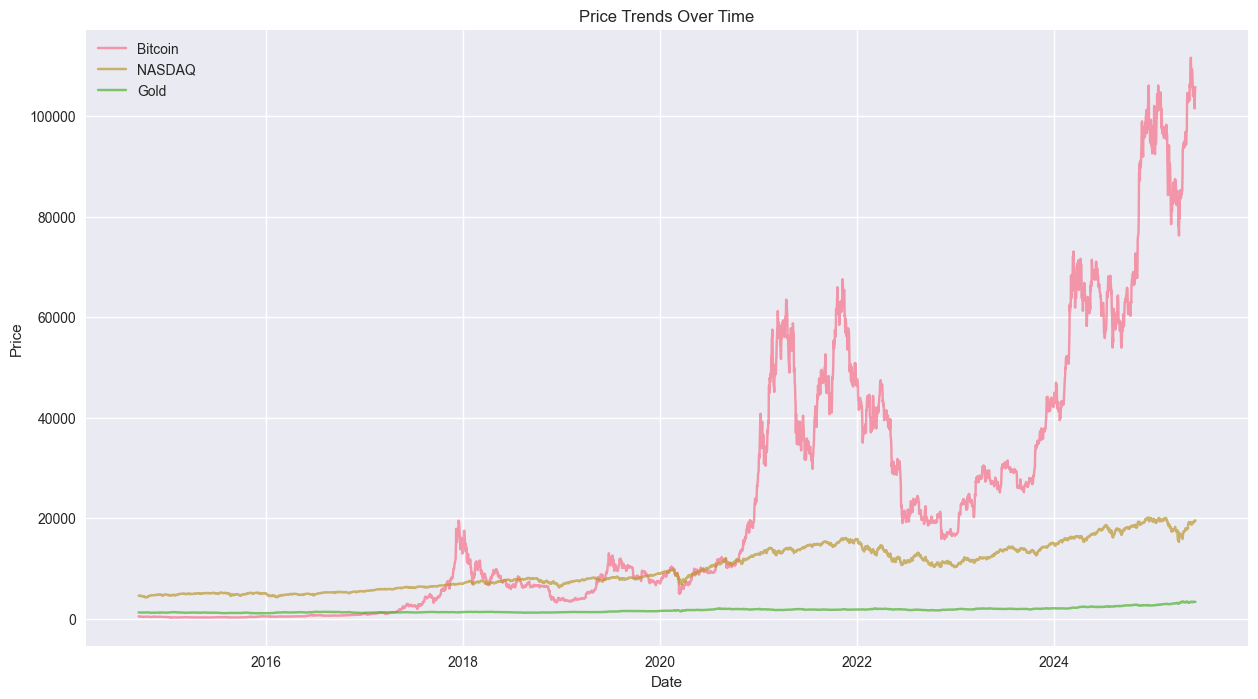

In [5]:
# 2. Time Series Analysis
plt.figure(figsize=(15, 8))
plt.plot(data['Date'], data['BTC Close'], label='Bitcoin', alpha=0.7)
plt.plot(data['Date'], data['NASDAQ Close'], label='NASDAQ', alpha=0.7)
plt.plot(data['Date'], data['Gold Close'], label='Gold', alpha=0.7)
plt.title('Price Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

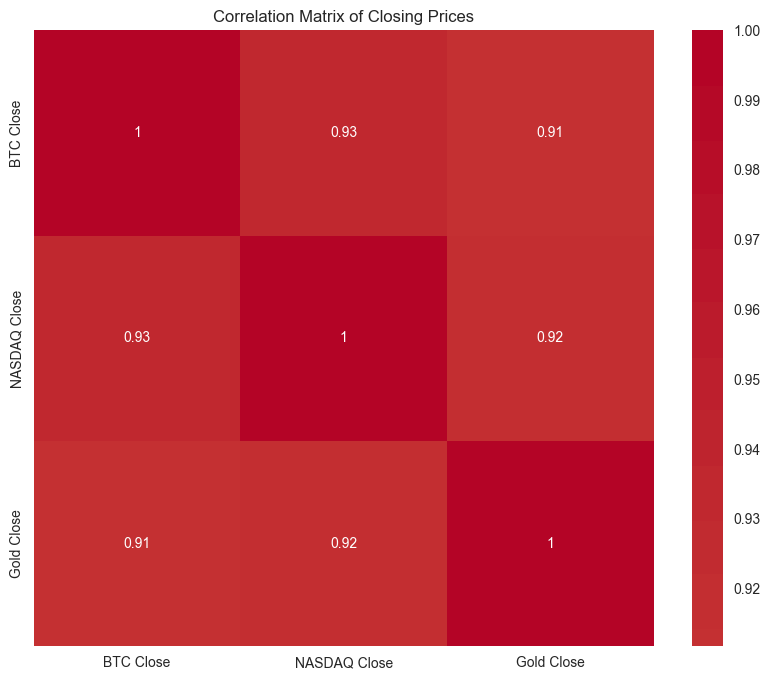

                BTC Returns  NASDAQ Returns  Gold Returns
BTC Returns        1.000000        0.221404      0.077151
NASDAQ Returns     0.221404        1.000000      0.027373
Gold Returns       0.077151        0.027373      1.000000


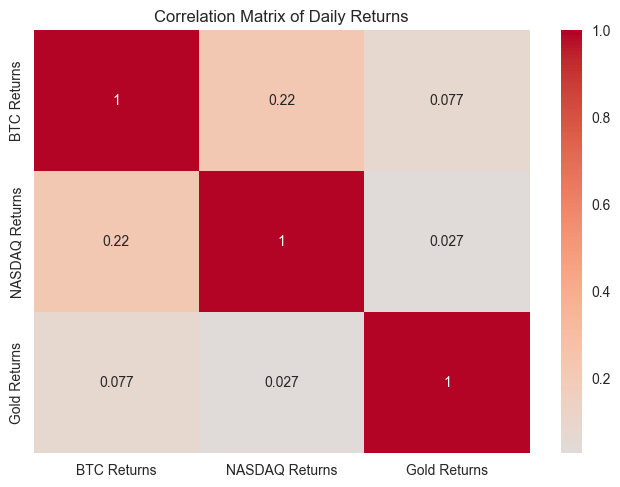

In [6]:
# 3. Correlation Analysis

# For long term view - Calculate correlations between closing prices
correlation_matrix = data[['BTC Close', 'NASDAQ Close', 'Gold Close']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Closing Prices')
plt.show()

# For short term view - Calculate daily returns
data['BTC Returns'] = data['BTC Close'].pct_change()
data['NASDAQ Returns'] = data['NASDAQ Close'].pct_change()
data['Gold Returns'] = data['Gold Close'].pct_change()

# Correlation of returns
returns_corr = data[['BTC Returns', 'NASDAQ Returns', 'Gold Returns']].corr()
print(returns_corr)
sns.heatmap(returns_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Daily Returns')
plt.show()

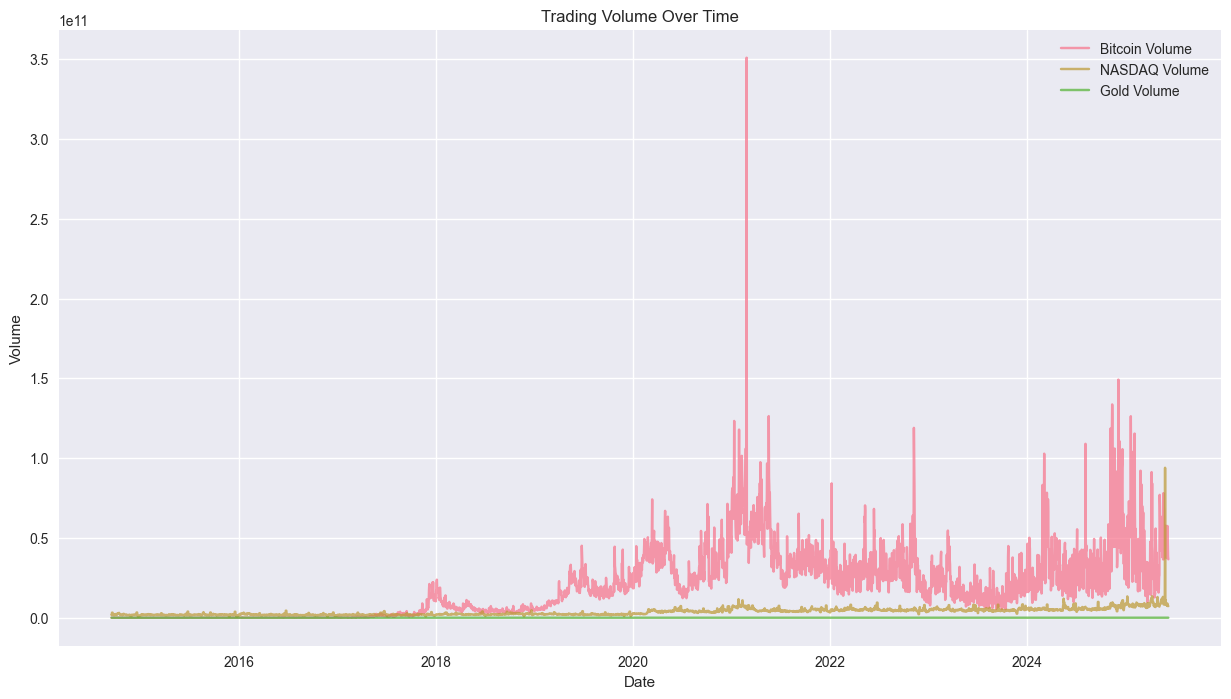

In [7]:
# 4. Volume Analysis
# Plot volume trends
plt.figure(figsize=(15, 8))
plt.plot(data['Date'], data['BTC Volume'], label='Bitcoin Volume', alpha=0.7)
plt.plot(data['Date'], data['NASDAQ Volume'], label='NASDAQ Volume', alpha=0.7)
plt.plot(data['Date'], data['Gold Volume'], label='Gold Volume', alpha=0.7)
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

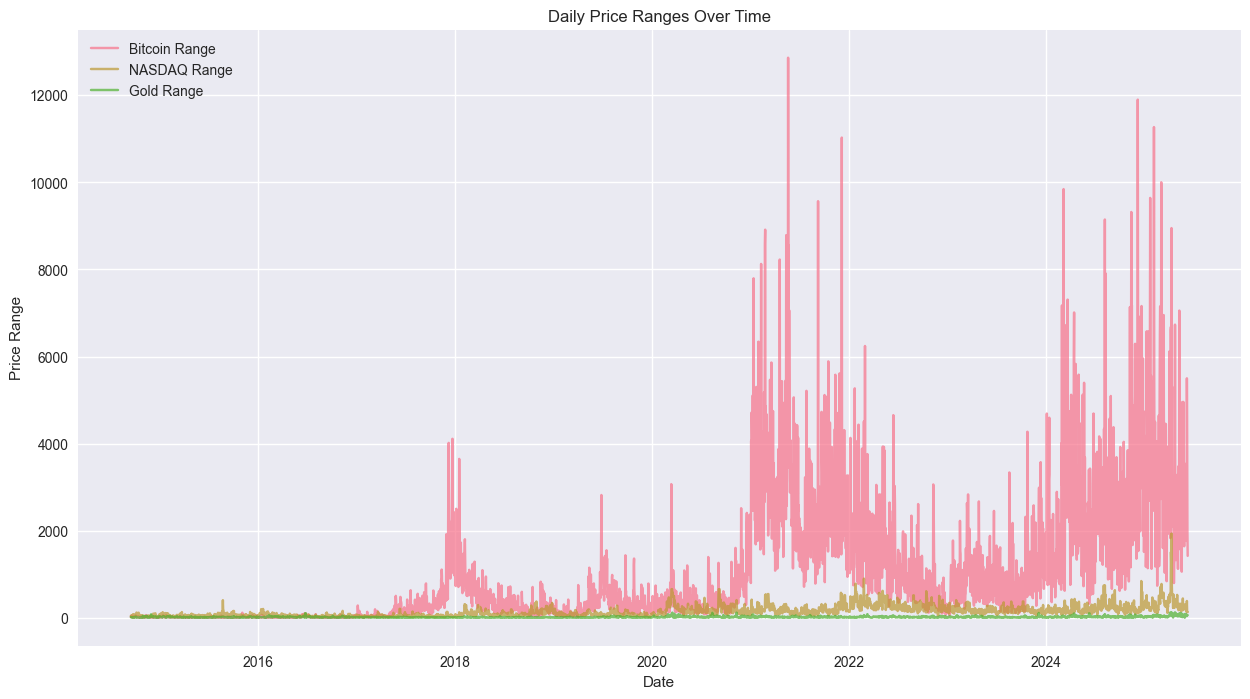

In [8]:
# 5. Price Range Analysis
# Calculate daily price ranges
data['BTC Range'] = data['BTC High'] - data['BTC Low']
data['NASDAQ Range'] = data['NASDAQ High'] - data['NASDAQ Low']
data['Gold Range'] = data['Gold High'] - data['Gold Low']

# Plot price ranges
plt.figure(figsize=(15, 8))
plt.plot(data['Date'], data['BTC Range'], label='Bitcoin Range', alpha=0.7)
plt.plot(data['Date'], data['NASDAQ Range'], label='NASDAQ Range', alpha=0.7)
plt.plot(data['Date'], data['Gold Range'], label='Gold Range', alpha=0.7)
plt.title('Daily Price Ranges Over Time')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.legend()
plt.show()

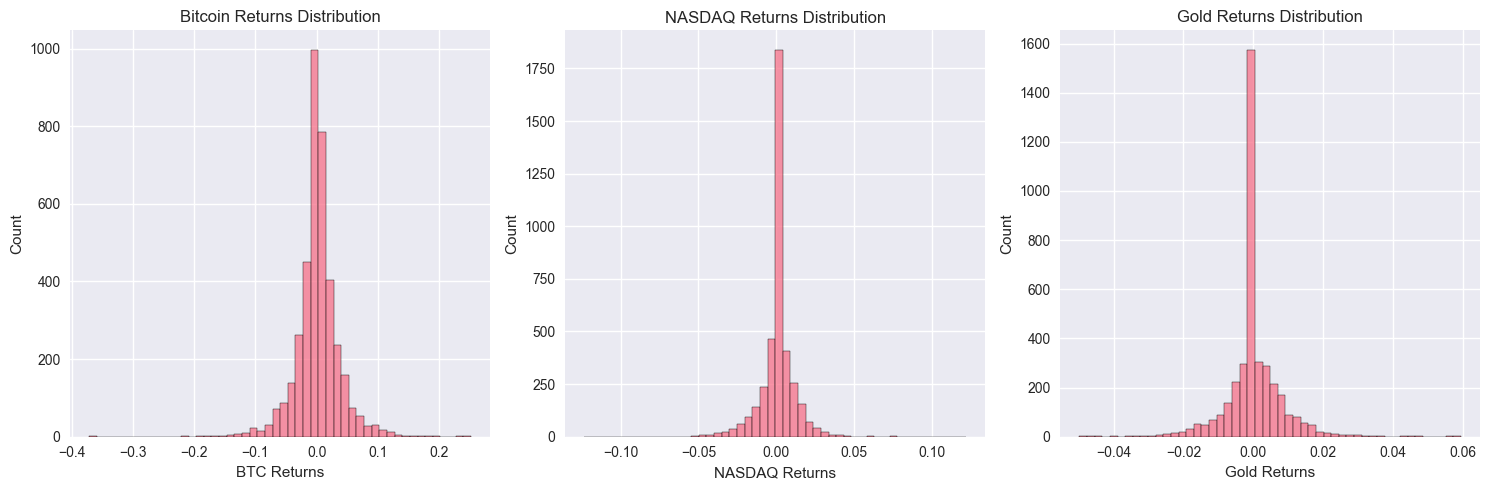

In [9]:
# 6. Returns Analysis
# Plot return distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data['BTC Returns'].dropna(), ax=axes[0], bins=50)
axes[0].set_title('Bitcoin Returns Distribution')
sns.histplot(data['NASDAQ Returns'].dropna(), ax=axes[1], bins=50)
axes[1].set_title('NASDAQ Returns Distribution')
sns.histplot(data['Gold Returns'].dropna(), ax=axes[2], bins=50)
axes[2].set_title('Gold Returns Distribution')
plt.tight_layout()
plt.show()

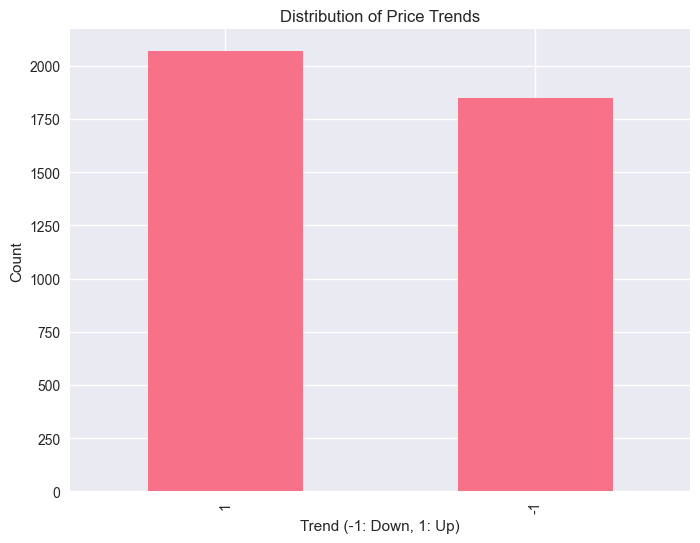

In [10]:
# 7. Trend Analysis
# Analyze trend distribution
trend_counts = data['Trend'].value_counts()
plt.figure(figsize=(8, 6))
trend_counts.plot(kind='bar')
plt.title('Distribution of Price Trends')
plt.xlabel('Trend (-1: Down, 1: Up)')
plt.ylabel('Count')
plt.show()

In [11]:
# 8. Summary Statistics
print("\n9. Summary Statistics")
print("\nBitcoin Price Statistics:")
print(data['BTC Close'].describe())
print("\nNASDAQ Price Statistics:")
print(data['NASDAQ Close'].describe())
print("\nGold Price Statistics:")
print(data['Gold Close'].describe())


9. Summary Statistics

Bitcoin Price Statistics:
count      3918.000000
mean      22632.465445
std       26311.110450
min         178.102997
25%        2052.082458
50%        9857.380860
75%       36845.432618
max      111673.281250
Name: BTC Close, dtype: float64

NASDAQ Price Statistics:
count     3918.000000
mean     10062.227339
std       4428.790960
min       4213.660156
25%       6134.892578
50%       8641.224610
75%      13694.620117
max      20173.890625
Name: NASDAQ Close, dtype: float64

Gold Price Statistics:
count    3918.000000
mean     1650.184788
std       481.018425
min      1050.800000
25%      1255.900000
50%      1557.650000
75%      1898.600000
max      3411.400000
Name: Gold Close, dtype: float64


# 2. Initial Predictive model

### Make sure data is still appropriate for modelling

In [12]:
data.head(5)

,Date,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,NASDAQ Open,NASDAQ High,NASDAQ Low,NASDAQ Close,...,Gold Low,Gold Close,Gold Volume,Trend,BTC Returns,NASDAQ Returns,Gold Returns,BTC Range,NASDAQ Range,Gold Range
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,4553.959961,4582.399902,4539.359863,4562.189941,...,1221.9,1234.4,10,-1,NaN,NaN,NaN,15.752014,43.040039,14.3
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,4575.740234,4593.979980,4572.620117,4593.430176,...,1216.2,1225.7,5,-1,-0.071926,0.006848,-0.007048,43.755981,21.359863,9.5
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,4606.129883,4610.569824,4563.439941,4579.790039,...,1215.3,1215.3,4,-1,-0.069843,-0.002969,-0.008485,43.302978,47.129883,3.0
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,4606.129883,4610.569824,4563.439941,4579.790039,...,1215.3,1215.3,4,1,0.035735,0.000000,0.000000,33.412994,47.129883,3.0
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,4606.129883,4610.569824,4563.439941,4579.790039,...,1215.3,1215.3,4,-1,-0.024659,0.000000,0.000000,19.244995,47.129883,3.0


### Baseline regression model for bitcoin price prediction

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# XGBoost and LightGBM
import xgboost as xgb
import lightgbm as lgb

In [14]:
# Add lag features
data['BTC Close Lag1'] = data['BTC Close'].shift(1)
data['NASDAQ Close Lag1'] = data['NASDAQ Close'].shift(1)
data['Gold Close Lag1'] = data['Gold Close'].shift(1)

# Drop rows with any missing values (if any)
model_data = data.dropna().copy()

# Remove date
model_data = model_data.drop(columns=['Date'])

# Compute correlation of all features with BTC Close
corrs = model_data.corr()['BTC Close'].abs().sort_values(ascending=False)
print("Top features most correlated with BTC Close:")
print(corrs)

N = 10
top_features = corrs.index[1:N+1]  # Skip the first (BTC Close itself)
print(f"\nTop {N} features for modeling:", list(top_features))

X = model_data[top_features]
y = model_data['BTC Close']

Top features most correlated with BTC Close:
BTC Close            1.000000
BTC High             0.999668
BTC Low              0.999582
BTC Close Lag1       0.999226
BTC Open             0.999225
NASDAQ Close         0.930506
NASDAQ High          0.930419
NASDAQ Low           0.930407
NASDAQ Close Lag1    0.930375
NASDAQ Open          0.930310
Gold Low             0.912002
Gold Close Lag1      0.911712
Gold Close           0.911695
Gold Open            0.911459
Gold High            0.911005
BTC Range            0.751792
NASDAQ Volume        0.699837
BTC Volume           0.660289
NASDAQ Range         0.531116
Gold Range           0.391558
Gold Returns         0.028036
Gold Volume          0.024218
Trend                0.015393
BTC Returns          0.005169
NASDAQ Returns       0.004661
Name: BTC Close, dtype: float64

Top 10 features for modeling: ['BTC High', 'BTC Low', 'BTC Close Lag1', 'BTC Open', 'NASDAQ Close', 'NASDAQ High', 'NASDAQ Low', 'NASDAQ Close Lag1', 'NASDAQ Open', 'Gold L

In [15]:
# 2. Train-test split (e.g., 80% train, 20% test, shuffle=False for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42, max_iter=500)
}

In [16]:
# 4. Fit, predict, and evaluate
# Scaling: fit on train, transform both train and test
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}
print("\n[INFO] SVR and MLP use scaled features; tree-based models use original features.")
for name, model in models.items():
    print(f"\nTraining {name}...")
    if name in ['SVR', 'MLP']:
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    results[name] = {
        'Train RMSE': train_rmse, 'Train MAE': train_mae, 'Train R2': train_r2,
        'Test RMSE': test_rmse, 'Test MAE': test_mae, 'Test R2': test_r2
    }
    print(f"{name} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f} | Train R^2: {train_r2:.4f} | Test R^2: {test_r2:.4f}")


[INFO] SVR and MLP use scaled features; tree-based models use original features.

Training Random Forest...
Random Forest | Train RMSE: 162.2620 | Test RMSE: 15421.6787 | Train R^2: 0.9999 | Test R^2: 0.6422

Training XGBoost...
XGBoost | Train RMSE: 94.9431 | Test RMSE: 16289.2865 | Train R^2: 1.0000 | Test R^2: 0.6008

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3133, number of used features: 10
[LightGBM] [Info] Start training from score 13236.414107
LightGBM | Train RMSE: 258.4134 | Test RMSE: 16451.5983 | Train R^2: 0.9997 | Test R^2: 0.5928

Training SVR...
SVR | Train RMSE: 16556.5235 | Test RMSE: 58292.2522 | Train R^2: -0.0649 | Test R^2: -4.1124

Training MLP...
MLP | T

/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# 5. Summary
print("\nBaseline Model Metrics:")
print(f"{'Model':<15} {'Train RMSE':>10} {'Test RMSE':>10} {'Train R2':>10} {'Test R2':>10}")
for name, metrics in results.items():
    print(f"{name:<15} {metrics['Train RMSE']:>10.4f} {metrics['Test RMSE']:>10.4f} {metrics['Train R2']:>10.4f} {metrics['Test R2']:>10.4f}")

# 3. Feature engineering and selection

### Feature engineering

In [18]:
# Feature Engineering: Lagged and Rolling Features

# 7-day and 30-day moving averages
data['BTC MA7'] = data['BTC Close'].rolling(window=7).mean()
data['BTC MA30'] = data['BTC Close'].rolling(window=30).mean()
data['NASDAQ MA7'] = data['NASDAQ Close'].rolling(window=7).mean()
data['NASDAQ MA30'] = data['NASDAQ Close'].rolling(window=30).mean()
data['Gold MA7'] = data['Gold Close'].rolling(window=7).mean()
data['Gold MA30'] = data['Gold Close'].rolling(window=30).mean()

# 7-day and 30-day rolling std (volatility)
data['BTC Volatility7'] = data['BTC Close'].rolling(window=7).std()
data['BTC Volatility30'] = data['BTC Close'].rolling(window=30).std()

# Drop rows with NaN values created by rolling/lags
data_fe = data.dropna().copy()
data_fe.head()

,Date,BTC Open,BTC High,BTC Low,BTC Close,BTC Volume,NASDAQ Open,NASDAQ High,NASDAQ Low,NASDAQ Close,...,NASDAQ Close Lag1,Gold Close Lag1,BTC MA7,BTC MA30,NASDAQ MA7,NASDAQ MA30,Gold MA7,Gold MA30,BTC Volatility7,BTC Volatility30
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-16,2014-10-16,394.518005,398.807007,373.070007,382.556000,26990000,4133.250000,4246.009766,4131.649902,4217.390137,...,4215.319824,1244.1,381.574720,384.112801,4243.180106,4438.583040,1230.071429,1217.270000,15.312384,32.045785
2014-10-17,2014-10-17,382.756012,385.477997,375.389008,383.757996,13600700,4275.089844,4296.109863,4241.669922,4258.439941,...,4217.390137,1240.5,384.745575,381.660267,4240.637207,4428.458040,1232.542857,1217.400000,12.521266,28.910903
2014-10-18,2014-10-18,383.976013,395.157990,378.971008,391.441986,11416800,4275.089844,4296.109863,4241.669922,4258.439941,...,4258.439941,1238.3,388.908857,380.560333,4238.094308,4417.291699,1235.014286,1217.820000,7.749794,27.834889
2014-10-19,2014-10-19,391.253998,393.938995,386.457001,389.545990,5914570,4275.089844,4296.109863,4241.669922,4258.439941,...,4258.439941,1238.3,390.479854,380.385333,4235.551409,4406.580029,1237.485714,1218.586667,6.273744,27.758701
2014-10-20,2014-10-20,389.230988,390.084015,378.252014,382.845001,16419000,4254.160156,4316.870117,4248.220215,4316.069824,...,4258.439941,1238.3,389.398568,379.516700,4250.181361,4397.789355,1239.585714,1219.543333,6.907262,27.238360


### Feature Selection

In [19]:
# Calculate correlation with BTC Close
corrs = data_fe.corr()['BTC Close'].sort_values(ascending=False)
print("Top features most correlated with BTC Close:")
print(corrs)

# Select top 10 features (excluding BTC Close itself). 10 is arbitrary number that I chose based on the correlation.
top_features = corrs.index[1:11]  # Top 10 features (excluding BTC Close itself)
print("\nTop 10 features for modeling:", list(top_features))

Top features most correlated with BTC Close:
BTC Close            1.000000
BTC High             0.999667
BTC Low              0.999580
BTC Close Lag1       0.999222
BTC Open             0.999221
BTC MA7              0.998658
BTC MA30             0.992862
NASDAQ MA7           0.930646
NASDAQ Close         0.930577
NASDAQ High          0.930482
NASDAQ Low           0.930475
NASDAQ Close Lag1    0.930438
NASDAQ Open          0.930372
NASDAQ MA30          0.930244
Gold MA30            0.913163
Gold MA7             0.911663
Gold Low             0.911529
Gold Close Lag1      0.911235
Gold Close           0.911219
Gold Open            0.910982
Gold High            0.910524
Date                 0.822788
BTC Volatility30     0.803494
BTC Volatility7      0.762322
BTC Range            0.750833
NASDAQ Volume        0.699018
BTC Volume           0.658365
NASDAQ Range         0.529431
Gold Range           0.389945
Gold Returns         0.028188
BTC Returns          0.004094
NASDAQ Returns       0.00

# 4. Improved predictive model

### Evaluate feature-engineered dataset 

In [20]:
X_fe = data_fe[top_features]
y_fe = data_fe['BTC Close']

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume you already have: data_fe, top_features, X_fe, y_fe

# 1. Train-test split (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, test_size=0.2, shuffle=False)

# 2. Scaling (fit on train, transform both train and test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Define models (same as before)
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor(random_state=42, max_iter=500)
}

# 4. Fit, predict, and evaluate
results = {}
for name, model in models.items():
    print(f"\nTraining {name} (with scaling)...")
    model.fit(X_train_scaled, y_train)

    # Train set
    y_train_pred = model.predict(X_train_scaled)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Test set
    y_test_pred = model.predict(X_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    results[name] = {
        'Train RMSE': train_rmse, 'Train MAE': train_mae, 'Train R2': train_r2,
        'Test RMSE': test_rmse, 'Test MAE': test_mae, 'Test R2': test_r2
    }
    print(f"{name} | Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f} | Train R^2: {train_r2:.4f} | Test R^2: {test_r2:.4f}")

# 5. (Optional) Print summary table
print("\nImproved Model Results (Feature Engineering + Scaling):")
print(f"{'Model':<15} {'Train RMSE':>10} {'Test RMSE':>10} {'Train R2':>10} {'Test R2':>10}")
for name, metrics in results.items():
    print(f"{name:<15} {metrics['Train RMSE']:>10.4f} {metrics['Test RMSE']:>10.4f} {metrics['Train R2']:>10.4f} {metrics['Test R2']:>10.4f}")


Training Random Forest (with scaling)...
Random Forest | Train RMSE: 168.26 | Test RMSE: 15594.88 | Train R^2: 0.9999 | Test R^2: 0.6326

Training XGBoost (with scaling)...
XGBoost | Train RMSE: 89.40 | Test RMSE: 16373.97 | Train R^2: 1.0000 | Test R^2: 0.5950

Training LightGBM (with scaling)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3111, number of used features: 10
[LightGBM] [Info] Start training from score 13381.873217
LightGBM | Train RMSE: 275.78 | Test RMSE: 16577.11 | Train R^2: 0.9997 | Test R^2: 0.5849

Training SVR (with scaling)...
SVR | Train RMSE: 16607.23 | Test RMSE: 58351.54 | Train R^2: -0.0682 | Test R^2: -4.1431

Training MLP (with scaling)...
MLP | Train RMSE: 3667.29 | Test RMSE: 5232.72 | Train R^2: 0.9479 | Test R^2: 0.9586

Improved Model Results 

/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
print(f"\n{'Feature-Engineered Features'}")
print(f"{'Model':<15} {'Train RMSE':>10} {'Test RMSE':>10} {'Train R2':>10} {'Test R2':>10}")
for name, metrics in results.items():
    print(f"{name:<15} {metrics['Train RMSE']:>10.4f} {metrics['Test RMSE']:>10.4f} {metrics['Train R2']:>10.4f} {metrics['Test R2']:>10.4f}")


Feature-Engineered Features
Model           Train RMSE  Test RMSE   Train R2    Test R2
Random Forest     168.2615 15594.8773     0.9999     0.6326
XGBoost            89.3979 16373.9658     1.0000     0.5950
LightGBM          275.7809 16577.1055     0.9997     0.5849
SVR             16607.2261 58351.5377    -0.0682    -4.1431
MLP              3667.2928  5232.7231     0.9479     0.9586


### Let's use GridSearchCV for Hyperparamter tuning

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define a focused parameter grid for MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [2000],
    'random_state': [42]
}

mlp = MLPRegressor()

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=mlp_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # Direct RMSE
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters for MLP:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

# Evaluate on train and test
best_mlp = grid_search.best_estimator_
y_train_pred = best_mlp.predict(X_train_scaled)
y_test_pred = best_mlp.predict(X_test_scaled)

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"Train R2: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R2: {r2_score(y_test, y_test_pred):.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   7.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   7.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   7.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   4.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  11.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  11.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  11.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  11.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  12.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   7.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   8.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   9.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  12.3s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  20.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   6.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   8.6s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  19.8s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  20.3s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  20.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  20.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   4.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   5.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   6.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   5.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  11.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; tota

/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  12.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  11.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  11.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   7.7s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  12.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  27.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   3.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  11.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   8.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   8.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   7.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  11.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  13.5s
[CV] END a

/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  22.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  23.3s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  23.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   9.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   6.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  23.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  23.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   5.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   6.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   7.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  10.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   4.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time

/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  16.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  15.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  28.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  15.7s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  15.8s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  15.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   4.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  10.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   9.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   8.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   8.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   8.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  19.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  11.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  19.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  19.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  20.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   8.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   6.0s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  20.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   3.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   5.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   7.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   3.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=   3.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  12.4s

/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  16.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  17.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  29.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  16.8s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  17.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  16.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  17.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  18.0s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  16.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  17.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  17.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  26.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  26.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  27.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  26.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  26.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  26.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  26.6s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  26.7s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  25.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  24.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  40.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  40.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  43.0s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  43.6s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  45.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  47.7s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  51.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  51.7s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  25.6s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  27.0s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  26.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  25.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  54.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.0min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  32.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  34.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  34.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  32.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  31.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  33.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  49.3s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  44.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  46.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  46.3s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  47.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  48.3s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  42.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  58.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  56.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  55.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.3min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.5min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.4min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.5min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.5min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.5min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.2min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  27.7s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.2min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  27.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  28.5s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  29.0s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.0min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  25.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  25.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  27.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  29.6s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  29.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.3min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  31.2s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  40.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  43.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  53.8s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  46.9s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2000, random_state=42; total time=  53.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  53.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.0min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.0min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  55.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  54.8s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.1min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.2min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.2min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.3min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  56.7s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time= 1.1min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  59.1s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.001, max_iter=2000, random_state=42; total time= 1.2min


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  44.4s


/Users/jven/anaconda3/envs/bootcamp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate_init=0.01, max_iter=2000, random_state=42; total time=  41.5s
Best parameters for MLP: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 2000, 'random_state': 42}
Best CV RMSE: 348.6476346006725
Train RMSE: 343.76
Test RMSE: 782.21
Train R2: 0.9995
Test R2: 0.9991
